In [5]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm as t
import sklearn.neighbors as sn
import numpy.matlib as ml
import skimage.transform as skt
from sklearn import svm
from sklearn.metrics import classification_report

## **Image Loading and Feature Extraction using Eigenvector**

In [6]:
datatrain = [];
labelTrain = [];

In [7]:
# Training Image Loader and Feature Extraction
for _classname in t.tqdm(range(1,7)):
    for _id in range(1,18):
        path = 'Char_Tr/Tr/' + str(_classname) + '/text (' + str(_id) + ').bmp';
        img = cv2.imread(path,cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA)
        img = np.invert(img)
        datatrain.append(np.array(img).reshape(-1,1))
        labelTrain.append(_classname)
tmpShape = np.array(datatrain).shape;
datatrain = np.reshape(np.array(datatrain),(-1,tmpShape[1])).T

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 109.07it/s]


In [8]:
datatrain

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,  11,   0, 255],
       [255, 184, 255, ...,   0,   0,   0],
       [255,   0, 255, ...,   0,   0,   0]], dtype=uint8)

In [9]:
# 1 Mean Calculation
meanData = np.array(np.mean(datatrain,1));
meanVector = np.array(meanData).reshape((meanData.shape[0],-1));
data0mean = datatrain - meanVector;
tmp = np.array(meanData).reshape((meanData.shape[0],-1))

In [10]:
# 2 Covariance Matrix
cov = (1.0/(data0mean.shape[0]-1))*(np.dot(data0mean.T, data0mean));

In [11]:
# 3 Extract Eigenvector and Eigenvalue 
val, vec = np.linalg.eig(cov);
idx = val.argsort()[::-1] 
val = val[idx]
vec = vec[:,idx]

In [12]:
# 4 Define Number of Eigenvector
PCs = 10
SelectedVec = vec[:,0:PCs];

In [13]:
# 5 Training Feature Extraction by using first ten eigenvectors
EigenFace = np.dot(data0mean, SelectedVec);
featureTr = np.dot(EigenFace.T, data0mean);
featureTr = featureTr.T;
featureTr.shape

(102, 10)

In [14]:
# 6 Testing Feature Extraction by using first ten eigenvectors
path = 'Char_Tr/Tr/5/text (19).bmp';
img = cv2.imread(path,cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA)
tmpTs = np.array(img).reshape(-1,1)
featureTs = np.dot(EigenFace.T, tmpTs-meanVector).T;
labelTs = 6

## **Model Training**

In [15]:
# 7 Image Classification
clf = svm.SVC(kernel='linear')
# train SVM model
clf.fit(featureTr, labelTrain)
# classify by using SVM
out = clf.predict(featureTs)
print('Answer is ' + str(out))

Answer is [1]


## **Model Testing**

In [16]:
testfeature = []
testlabel = []

In [17]:
for _classname in t.tqdm(range(1,7)):
    for _id in range(17,21):
        path = 'Char_Tr/Tr/' + str(_classname) + '/text (' + str(_id) + ').bmp';
        img = cv2.imread(path,cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA)
        img = np.invert(img)
        tmpTs = np.array(img).reshape(-1,1)
        testfeature.append(np.dot(EigenFace.T, tmpTs-meanVector).T)
        testlabel.append(_classname)
tmpShape = np.array(testfeature).shape;
datatrain = np.reshape(np.array(testfeature),(-1,tmpShape[1])).T

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 600.14it/s]


In [18]:
np.array(testfeature).shape

(24, 1, 10)

In [19]:
testfeature = np.reshape(np.array(testfeature),(24,-1))

In [20]:
clf.score(testfeature, testlabel)

0.9583333333333334

## **Predict Section**

In [35]:
#Change path of prediction here
path = 'Char_Tr/Tr/6/text (15).bmp';
img = cv2.imread(path,cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA)
img = np.invert(img)
tmpTs = np.array(img).reshape(-1,1)
featureTs = np.dot(EigenFace.T, tmpTs-meanVector).T;
labelTs = 2
out = clf.predict(featureTs)
print('The image is predicted as class ' + str(out))

The image is predicted as class [6]


## **Evaluation**

In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
prediction = clf.predict(testfeature)

In [24]:
prediction

array([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 3,
       6, 6])

In [25]:
print(classification_report(testlabel, prediction))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       0.80      1.00      0.89         4
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         4
           6       1.00      0.75      0.86         4

    accuracy                           0.96        24
   macro avg       0.97      0.96      0.96        24
weighted avg       0.97      0.96      0.96        24



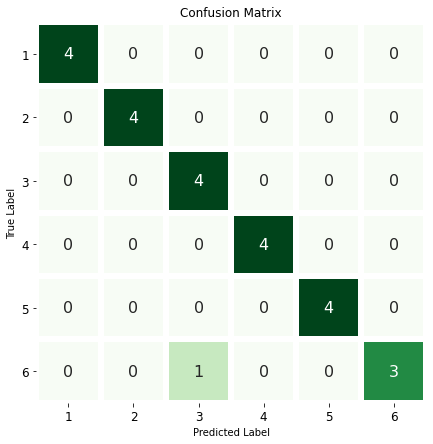

In [26]:
cm = confusion_matrix(testlabel, prediction)
df1 = pd.DataFrame(columns=[1, 2, 3, 4, 5, 6], index= [1, 2, 3, 4, 5, 6], data= cm)
f,ax = plt.subplots(figsize=(7,7))


sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',
            ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("Confusion Matrix", size = 12)
plt.show()